In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [3]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'


In [4]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [32]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


In [33]:
selected_sequence = 'DKMDAWLSGPNANK'
selected_sequence_charge = 2
selected_sequence_file = '190719_Hela_Ecoli_1to3_01'
selected_sequence_file_idx = file_idx_for_run(selected_sequence_file)

In [34]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_df = pd.read_sql_query('select * from features where sequence==\'{}\' and charge=={} and file_idx=={}'.format(selected_sequence,selected_sequence_charge,selected_sequence_file_idx), db_conn)
db_conn.close()

In [35]:
selected_sequence_df

,sequence,charge,file_idx,peak_idx,target_coords,theoretical_mz,q_value,delta_mz_ppm,delta_rt,delta_scan,...,mono_rt_bounds,monoisotopic_mass,monoisotopic_mz_centroid,number_of_isotopes,rt_apex,scan_apex,run_name,batch,human,number_of_runs_extracted
0,DKMDAWLSGPNANK,2,5,0,"{""mono_mz"": 773.8693700862513, ""scan_apex"": 54...",773.869576,0.000003,1.678206,0.001073,0.000545,...,"[525.4021148276895, 535.6368176164333]",1545.727065,773.870808,6,529.733479,549.0,190719_Hela_Ecoli_1to3_01,1to3,0,20


In [36]:
isotope_intensities_l = json.loads(selected_sequence_df.iloc[0].isotope_intensities_l)

In [37]:
isotope_intensities_df = pd.DataFrame(isotope_intensities_l, columns=['summed_intensity','saturated','inferred_intensity','inferred','isotope_points','isotope_apex_points'])


In [39]:
isotope_intensities_df['mz'] = isotope_intensities_df.apply(lambda row: row.isotope_points[0][0], axis=1)

In [40]:
isotope_intensities_df

,summed_intensity,saturated,inferred_intensity,inferred,isotope_points,isotope_apex_points,mz
0,22062.0,True,28364.0,True,"[[773.8677416843541, 523.0, 4961.0, 526.504311...","[[773.8677423355678, 552.0, 4986.0, 529.205213...",773.867742
1,18459.0,True,23599.0,True,"[[774.3694957188518, 523.0, 4971.0, 527.569927...","[[774.3694963704877, 547.0, 4986.0, 529.205213...",774.369496
2,8931.0,True,10977.0,True,"[[774.8714123655761, 523.0, 4961.0, 526.504311...","[[774.8714130176345, 550.0, 4986.0, 529.205213...",774.871412
3,3692.0,False,3692.0,False,"[[775.3734916245216, 523.0, 4956.0, 525.967528...","[[775.3778588967632, 555.0, 4986.0, 529.205213...",775.373492
4,1152.0,False,1152.0,False,"[[775.8757334956815, 527.0, 4971.0, 527.569927...","[[775.8757341485854, 547.0, 4986.0, 529.205213...",775.875733
5,466.0,False,466.0,False,"[[776.3781379790515, 524.0, 4956.0, 525.967528...","[[776.3781386323781, 551.0, 4986.0, 529.205213...",776.378138


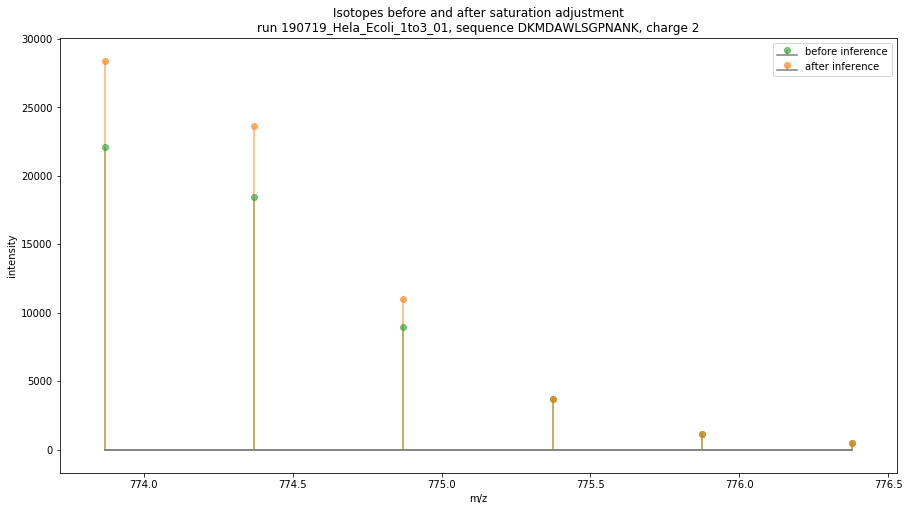

In [41]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz, isotope_intensities_df.summed_intensity, use_line_collection=True, label='before inference')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz, isotope_intensities_df.inferred_intensity, use_line_collection=True, label='after inference')
plt.setp(markerline, 'color', 'tab:orange')
plt.setp(stemlines, 'color', 'tab:orange')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)
plt.legend(loc='best')
plt.title('Isotopes before and after saturation adjustment\nrun {}, sequence {}, charge {}'.format(selected_sequence_file, selected_sequence, selected_sequence_charge))
plt.show()